In [4]:
import time
import numpy as np
import capytaine as cpt
import scipy
from capytaine.io.mesh_writers import write_STL
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import vtk
import logging

import xarray as xr
from capytaine.io.xarray import merge_complex_values
# 频域计算所需要导入的库
# 1、capytaine
# 2、python科学计算工具及绘图工具
# 3、自编函数，用于模块化计算
from Geometry import Create_geometry
from Calculate import hydro
from capytaine.post_pro import rao
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

INFO    : 	--> Mesh is not closed, meshmagick cannot test if the normals are outward
INFO    : 	--> Mesh is not closed, meshmagick cannot test if the normals are outward
INFO    : 	--> Mesh is not closed, meshmagick cannot test if the normals are outward
INFO    : 	--> Mesh is not closed, meshmagick cannot test if the normals are outward
INFO    : 	--> Mesh is not closed, meshmagick cannot test if the normals are outward
INFO    : 	--> Mesh is not closed, meshmagick cannot test if the normals are outward
INFO    : New floating body: rectangular_parallelepiped_12.
INFO    : The rotation dof Roll has been initialized around the point: rectangular_parallelepiped_12.center_of_mass = (0, 0, -1)
INFO    : The rotation dof Pitch has been initialized around the point: rectangular_parallelepiped_12.center_of_mass = (0, 0, -1)
INFO    : The rotation dof Yaw has been initialized around the point: rectangular_parallelepiped_12.center_of_mass = (0, 0, -1)
INFO    : Clipping rectangular_parallelepip

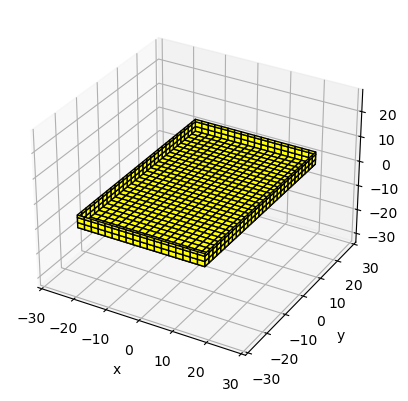

INFO    : New floating body: 0_0+1_0+2_0+3_0+4_0+5_0+6_0+7_0.


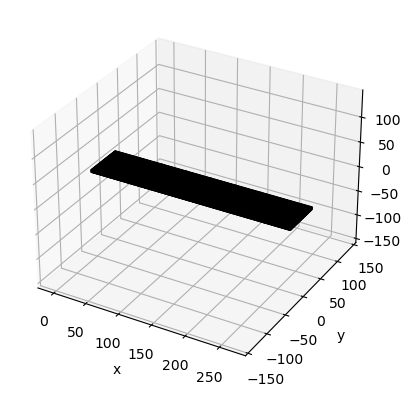

In [7]:
#建立水动力模型
body = Create_geometry(x=37.5,y=60,z=8,h=-1,m=37.5*60*5*1025,nx_distance=37.51,ny_distance=0,nx=8,ny=1,dof=6,mesh=2)

In [8]:
omegas = np.linspace(0.2,2,20)
depth = -58.5
wave_direction = 0
problems = [cpt.RadiationProblem(body=body, omega=omega,rho=1025,sea_bottom=depth,radiating_dof=dof) for dof in body.dofs for omega in omegas]
problems += [cpt.DiffractionProblem(omega=omega, body=body,rho=1025,wave_direction=wave_direction,sea_bottom=depth) for omega in omegas]

bem_solver = cpt.BEMSolver()
start_time = time.perf_counter()#运行时间
result = bem_solver.solve_all(problems)
dataset = cpt.assemble_dataset(result,wavelength=True) 

INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=0_0__Surge, rho=1025).
INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=0_0__Sway, rho=1025).
INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=0_0__Heave, rho=1025).
INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=0_0__Roll, rho=1025).
INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=0_0__Pitch, rho=1025).
INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=0_0__Yaw, rho=1025).
INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=1_0__Surge, rho=1025).
INFO    : Solve RadiationProblem(body=array_of_body_0828, omega=0.200, depth=58.5, radiating_dof=1_0__Sway, rho=1025).
INFO    : Solve RadiationProblem(body=array_o

In [10]:
dataset

<xarray.Dataset>
Dimensions:                (omega: 20, radiating_dof: 48, influenced_dof: 48,
                            wave_direction: 1)
Coordinates:
    g                      float64 9.81
    rho                    int64 1025
    body_name              <U18 'array_of_body_0828'
    water_depth            float64 58.5
  * omega                  (omega) float64 0.2 0.2947 0.3895 ... 1.811 1.905 2.0
  * radiating_dof          (radiating_dof) object '0_0__Surge' ... '7_0__Yaw'
  * influenced_dof         (influenced_dof) object '0_0__Surge' ... '7_0__Yaw'
  * wave_direction         (wave_direction) float64 0.0
    wavelength             (omega) float64 722.6 466.4 328.2 ... 16.98 15.41
Data variables:
    added_mass             (omega, radiating_dof, influenced_dof) float64 2.9...
    radiation_damping      (omega, radiating_dof, influenced_dof) float64 -8....
    diffraction_force      (omega, wave_direction, influenced_dof) complex128 ...
    Froude_Krylov_force    (omega, wave_direction, influenced_dof) complex128 ...
    inertia_matrix         (influenced_dof, radiating_dof) float64 1.153e+07 ...
    hydrostatic_stiffness  (influenced_dof, radiating_dof) float64 0.0 ... 0.0
Attributes:
    creation_of_dataset:        2023-12-07T17:11:28.090611
    incoming_waves_convention:  nemoh
    capytaine_version:          1.5

In [9]:
cpt.io.xarray.separate_complex_values(dataset).to_netcdf(f'Time_test_8module.nc',
            encoding={'radiating_dof': {'dtype': 'U'},
                        'influenced_dof': {'dtype': 'U'}})